### Import libraries

In [1]:
import math

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [6]:
from pmdarima import auto_arima

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
import warnings
warnings.filterwarnings("ignore");

### Loading dataset

In [9]:
df = pd.read_csv('purchases_monthly.csv')

In [10]:
df.head()

,dim_product_sk,year_month,amount,quantity,year,month
0,5,2019-01,4008.34,95.0,2019,1
1,5,2019-02,8282.05,197.0,2019,2
2,5,2019-03,5168.46,123.0,2019,3
3,5,2019-04,3659.85,87.0,2019,4
4,5,2019-05,6643.27,158.0,2019,5


### Data information

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180831 entries, 0 to 180830
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dim_product_sk  180831 non-null  int64  
 1   year_month      180831 non-null  object 
 2   amount          180831 non-null  float64
 3   quantity        180831 non-null  float64
 4   year            180831 non-null  int64  
 5   month           180831 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 8.3+ MB


### Data Cleaning

### Check for missing values

In [12]:
print(f"Number of rows with missing values: \n{df.isna().sum()}")

Number of rows with missing values: 
dim_product_sk    0
year_month        0
amount            0
quantity          0
year              0
month             0
dtype: int64


### Check for duplicate values

In [13]:
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


### Check for negative values

In [14]:
print(f"Negative quantity rows: {(df['quantity'] < 0).sum()}")
print(f"Negative amount rows: {(df['amount'] < 0).sum()}")

Negative quantity rows: 0
Negative amount rows: 0


### Univariate analysis

### Unique products

In [15]:
print(f"Unique SK Products : {df['dim_product_sk'].nunique()}")

Unique SK Products : 2289


### Monthly sold quantity

<Axes: xlabel='month'>

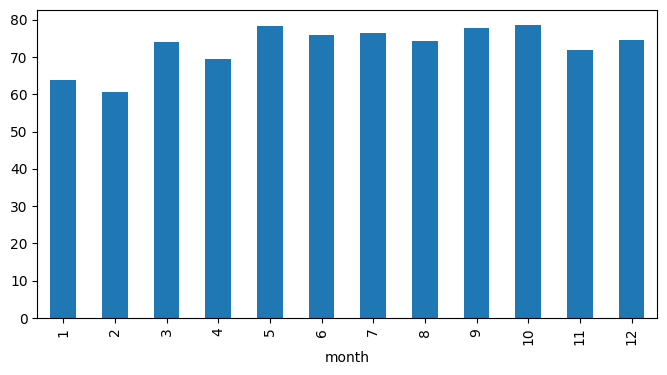

In [16]:
df.groupby('month')['quantity'].mean().plot(kind="bar", figsize=(8, 4))

### Monthly sold amount

<Axes: xlabel='month'>

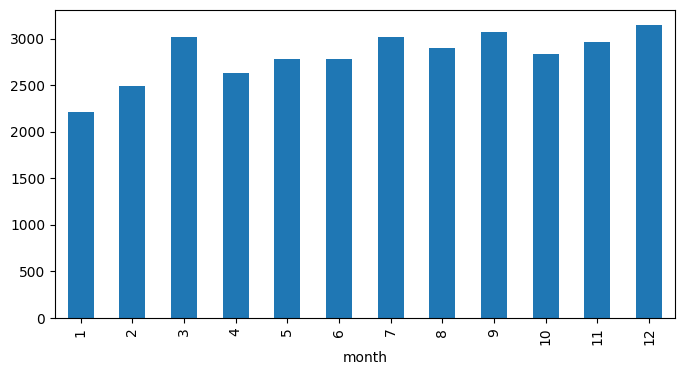

In [17]:
df.groupby('month')['amount'].mean().plot(kind="bar", figsize=(8,4))

### Yearly sold quantity

<Axes: xlabel='year'>

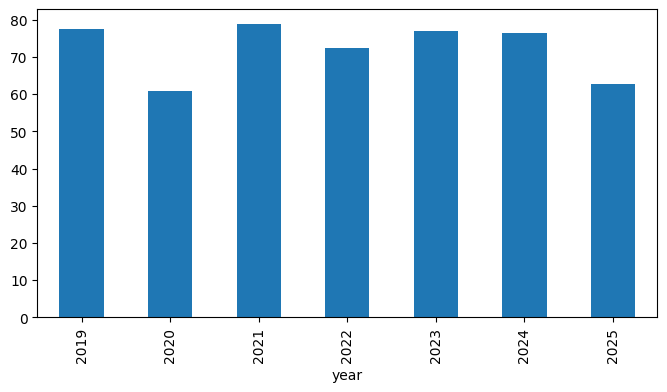

In [18]:
df.groupby('year')['quantity'].mean().plot(kind='bar', figsize=(8,4))

### Yearly sold amount

<Axes: xlabel='year'>

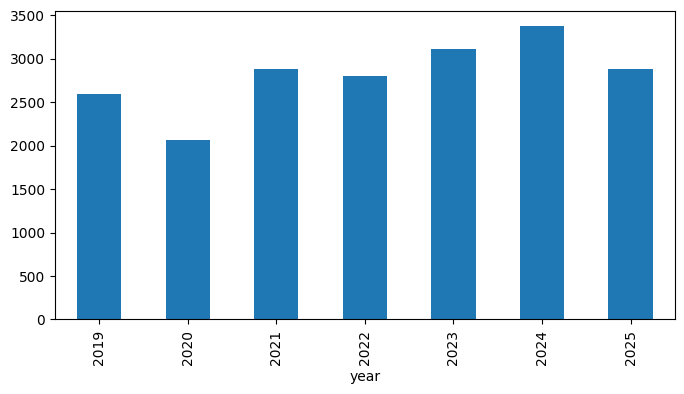

In [19]:
df.groupby('year')['amount'].mean().plot(kind='bar', figsize=(8,4))

### Decomposition

In [20]:
df['year_month'] = pd.to_datetime(df['year_month'])

### Visualizing for trends

In [21]:
df_trends = df.groupby('year_month')['quantity'].sum()

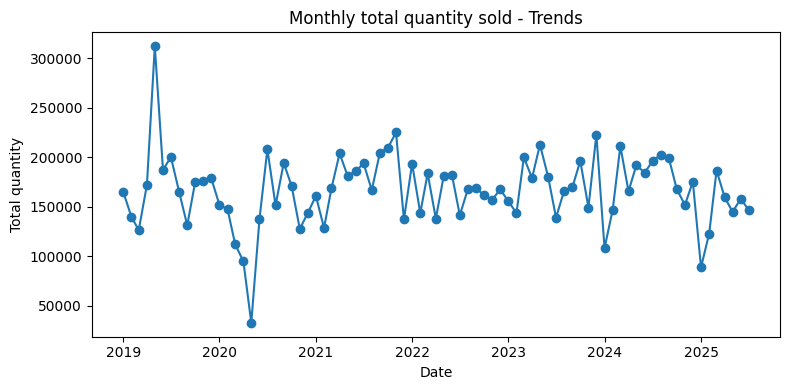

In [22]:
plt.figure(figsize=(8,4))
plt.plot(df_trends.index, df_trends.values, label="Quantity sold", marker = 'o')
plt.title('Monthly total quantity sold - Trends')
plt.xlabel('Date')
plt.ylabel('Total quantity')
plt.tight_layout()
plt.show()

### Visualizing for seasonality

In [23]:
df_seasonality = df.groupby('month')['quantity'].mean()

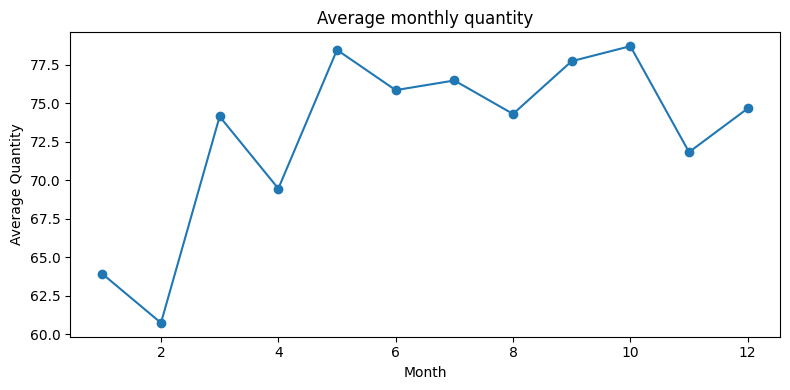

In [24]:
plt.figure(figsize=(8, 4))
plt.plot(df_seasonality.index, df_seasonality.values, marker='o', label='Quantity sold')
plt.title('Average monthly quantity')
plt.xlabel('Month')
plt.ylabel('Average Quantity')
plt.tight_layout()
plt.show()

### Visualizing noise

In [25]:
df_ts_decomposition = seasonal_decompose(df['quantity'], model='additive', period=12)

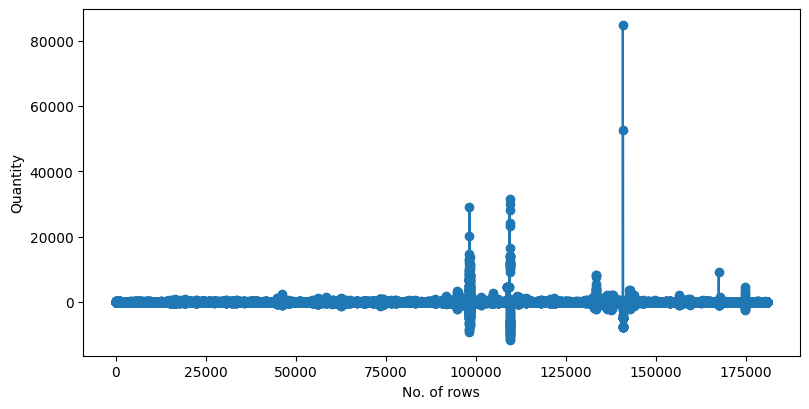

In [26]:
plt.figure(figsize=(8,4))
residuals = df_ts_decomposition.resid
reisduals = residuals.dropna()
plt.plot(residuals.index, residuals, label="Noise", marker='o')
plt.tight_layout()
plt.xlabel('No. of rows')
plt.ylabel('Quantity')
plt.show()

## ADF test

In [27]:
df_monthly = df.groupby('year_month')['quantity'].sum()

In [28]:
adftest_result = adfuller(df_monthly)

In [29]:
print('ADF Test on monthly quantity \n')
print("ADF Test Statistic:", adftest_result[0])
print(f"p-value: , {adftest_result[1]:.10f}")
print("Lags Used:", adftest_result[2])
print("Number of Observations:", adftest_result[3])

print("Critical Values:")
for key, value in adftest_result[4].items():
    print(f"   {key}: {value:.3f}")

if adftest_result[1] <= 0.05:
    print("Series is stationary - reject null hypothesis")
else:
    print("Series is non-stationary - (fail to reject null hypothesis)")

ADF Test on monthly quantity 

ADF Test Statistic: -6.77095996513049
p-value: , 0.0000000026
Lags Used: 0
Number of Observations: 78
Critical Values:
   1%: -3.517
   5%: -2.899
   10%: -2.587
Series is stationary - reject null hypothesis


### Autocorrelation function test

<Figure size 800x400 with 0 Axes>

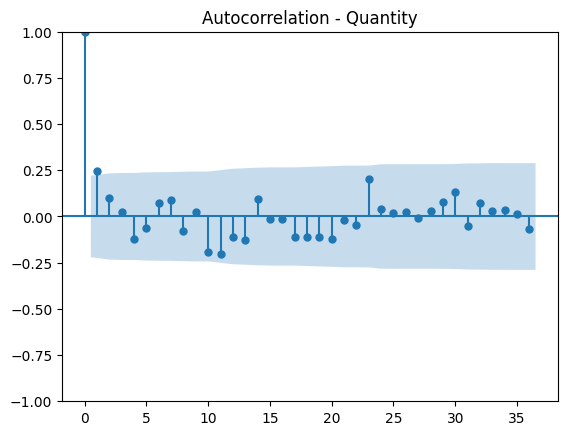

In [30]:
plt.figure(figsize=(8, 4))
plot_acf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

### Partial autocorrelation function test

<Figure size 800x400 with 0 Axes>

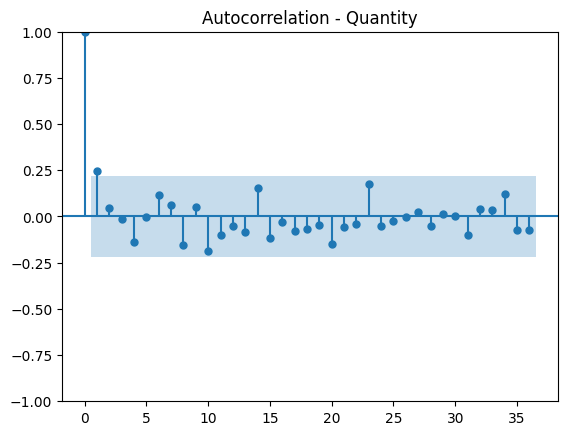

In [31]:
plt.figure(figsize=(8, 4))
plot_pacf(df_monthly, lags=36)
plt.title("Autocorrelation - Quantity")
plt.show()

# Prophet model
Prophet model is designed as a univariate time series forecasting. We have one datetime column and one target column.

### Feauture selection for Prophet model

In [32]:
df_for_prophet = df.drop(columns=['year', 'month', 'dim_product_sk', 'amount'], axis=1)

In [33]:
df_for_prophet.head()

,year_month,quantity
0,2019-01-01,95.0
1,2019-02-01,197.0
2,2019-03-01,123.0
3,2019-04-01,87.0
4,2019-05-01,158.0


### Grouping
Grouping quantites of all products by months.

In [34]:
df_final = (
    df_for_prophet.groupby('year_month', as_index=False).agg({'quantity': 'sum'})
)

In [35]:
df_for_prophet = df_final.copy()

In [36]:
df_for_prophet.head(5)

,year_month,quantity
0,2019-01-01,165313.0
1,2019-02-01,140022.0
2,2019-03-01,126374.0
3,2019-04-01,172013.0
4,2019-05-01,312183.0


In [37]:
df_for_prophet['year_month'] = pd.to_datetime(df_for_prophet['year_month'])

### Changing column names

In [38]:
df_for_prophet = df_for_prophet[['year_month', 'quantity']].rename(columns={'year_month':'ds', 'quantity' : 'y'})

In [39]:
df_for_prophet.head(2)

,ds,y
0,2019-01-01,165313.0
1,2019-02-01,140022.0


### Train test split

In [40]:
H = 12 # 12 months 

In [41]:
train = df_for_prophet.iloc[:-H].copy()
test = df_for_prophet.iloc[-H:].copy()

### Defining model

In [42]:
prophet_model = Prophet(
    growth='linear',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    interval_width=0.80    
)

### Fitting model

In [43]:
prophet_model.fit(train)

16:58:13 - cmdstanpy - INFO - Chain [1] start processing
16:58:14 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

In [44]:
future = prophet_model.make_future_dataframe(periods=H, freq='MS')

In [45]:
forecast = prophet_model.predict(future)

### Model Evaluation

In [46]:
pred_vs_actual = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_for_prophet.set_index('ds')['y'])

In [47]:
pred_test = pred_vs_actual.loc[test['ds']]

In [48]:
y_true = pred_test['y'].values

In [49]:
y_pred  = pred_test['yhat'].values

In [50]:
mae  = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = math.sqrt(mse)
mape = (np.abs((y_true - y_pred) / y_true).mean() * 100)
accuracy = 100-mape

In [51]:
print("\nModel Evaluation\n")
print(f"MAE:  {mae:,.2f}")
print(f"MSE:  {mse:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


Model Evaluation

MAE:  31,128.04
MSE:  1,720,680,607.96
RMSE: 41,481.09
MAPE: 24.29%
Accuracy: 75.71%


### Final Forecasting

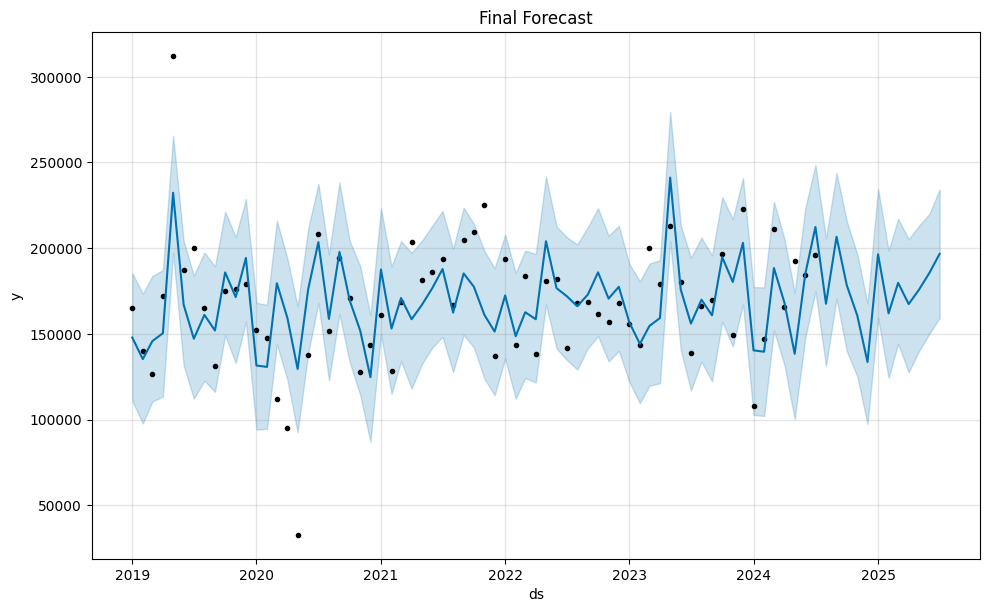

In [52]:
fig1 = prophet_model.plot(forecast)
plt.title('Final Forecast')
plt.show()

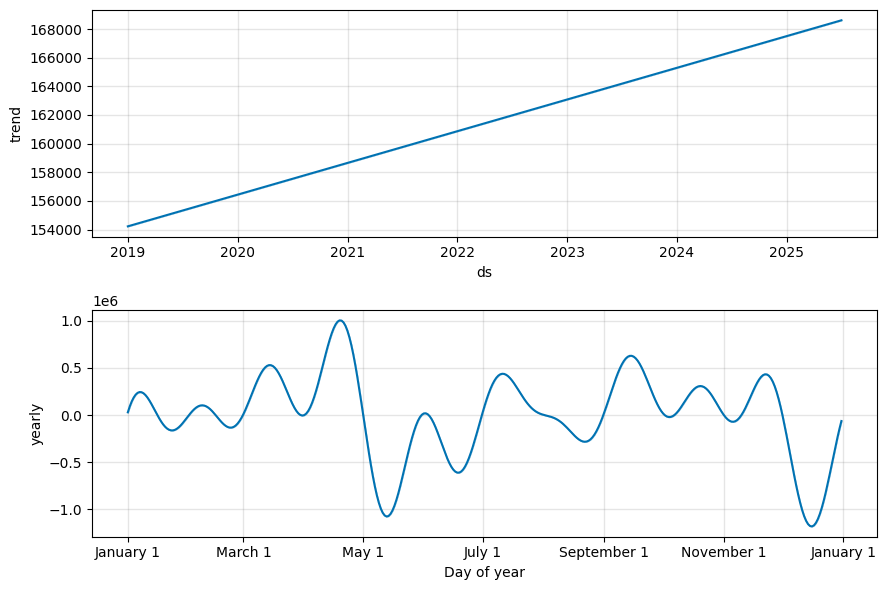

In [53]:
fig2 = prophet_model.plot_components(forecast)
plt.show()

### Forecasting 2026

In [54]:
future = prophet_model.make_future_dataframe(periods=24, freq='MS')

In [55]:
forecast = prophet_model.predict(future)

In [56]:
forecast_2026 = forecast[forecast['ds'].dt.year == 2026]
print(forecast_2026[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds           yhat     yhat_lower     yhat_upper
84 2026-01-01  181254.911743  143688.177485  216933.731237
85 2026-02-01  157476.423243  116292.375092  193810.046887
86 2026-03-01  171449.858184  136529.135020  207342.799560
87 2026-04-01  167382.470473  132108.652007  206560.571777
88 2026-05-01  212909.217983  175229.321910  251159.738682
89 2026-06-01  185536.430151  147744.627234  225122.913441
90 2026-07-01  180846.744055  142672.225390  217164.300392


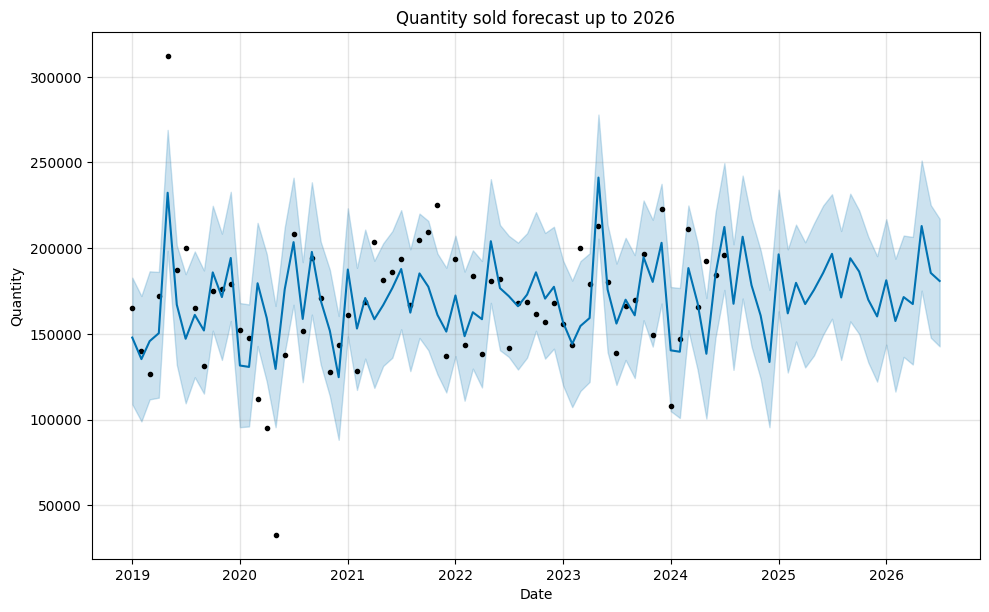

In [57]:
fig = prophet_model.plot(forecast)
plt.title("Quantity sold forecast up to 2026")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.show()

# ARIMA

ARIMA for forecasting

In [58]:
df_arima = df_final.copy()

### Train test split

In [59]:
split = int(len(df_final) * 0.8) 

In [60]:
train = df_arima['quantity'][:split]
test = df_arima['quantity'][split:]

In [61]:
print(f"Training set: {len(train)} observations")
print(f"Test set: {len(test)} observations")

Training set: 63 observations
Test set: 16 observations


### Auto ARIMA

In [62]:
y = train

In [63]:
auto_model = auto_arima(
    y,
    start_p=0, start_q=0,
    max_p=5, max_q=5, 
    d=1,           
    seasonal=False,   
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore',
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1513.845, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1505.185, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1502.215, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1511.868, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1507.293, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1509.211, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1500.512, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1496.651, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1503.261, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1501.959, Time=0.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0

In [64]:
print(f"Best model: {auto_model.order}")

Best model: (1, 1, 1)


### Final ARIMA model

In [65]:
best_order = auto_model.order

In [66]:
final_model = ARIMA(y, order=best_order)

### Fit ARIMA

In [67]:
arima_fitted = final_model.fit()

### Summary of ARIMA

In [68]:
print(arima_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:               quantity   No. Observations:                   63
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -745.325
Date:                Mon, 29 Sep 2025   AIC                           1496.651
Time:                        16:58:15   BIC                           1503.032
Sample:                             0   HQIC                          1499.156
                                 - 63                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3168      0.112      2.824      0.005       0.097       0.537
ma.L1         -0.9794      0.069    -14.286      0.000      -1.114      -0.845
sigma2      1.379e+09   4.92e-11    2.8e+19      0.0

### Forecast using ARIMA

In [69]:
forecast = arima_fitted.forecast(steps=len(test))

### ARIMA model Evaluation

In [70]:
arima_mae = mean_absolute_error(test, forecast)
arima_mse = mean_squared_error(test, forecast)
arima_rmse = np.sqrt(mse)
arima_mape = (np.abs((test - forecast) / test).mean() * 100)
accuracy = 100-arima_mape

In [71]:
print("\nModel Evaluation: \n")
print(f"MAE:  {arima_mae:,.2f}")
print(f"MSE:  {arima_mse:,.2f}")
print(f"RMSE: {arima_rmse:,.2f}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


Model Evaluation: 

MAE:  23,346.82
MSE:  856,831,771.52
RMSE: 41,481.09
MAPE: 16.51%
Accuracy: 83.49%


# SARIMAX
Forecasting with SARIMAX

In [72]:
df_sarimax = df_final.copy()
df_sarimax['year_month'] = pd.to_datetime(df_sarimax['year_month'])
df_sarimax = df_sarimax.set_index('year_month')

### Train Test Split

In [73]:
train = df_sarimax[:split]
y_train = train['quantity']
test = df_sarimax[split:]

### Auto Arima
To find best order

In [74]:
model = auto_arima(
    y_train,
    seasonal = True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1510.382, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1510.254, Time=0.09 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1509.305, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1699.318, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1509.620, Time=0.00 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1511.235, Time=0.21 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1511.072, Time=0.07 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=1511.442, Time=0.09 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1513.008, Time=0.14 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1508.878, Time=0.02 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1510.851, Time=0.20 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1510.874, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1512.251, Time=0.03 sec
 ARIMA(0,0,0)(1,0,2)[12]

### Model summary

In [75]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -750.407
Date:                              Mon, 29 Sep 2025   AIC                           1508.815
Time:                                      16:58:18   BIC                           1517.387
Sample:                                  01-01-2019   HQIC                          1512.187
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.291e+05   2.82e+04      4.582      0.000    7.39e+04    1.84e+05
ar.L1          0.22

### Best order

In [76]:
print("Best order (p,d,q): ", model.order) 

Best order (p,d,q):  (1, 0, 0)


### Seasoanl order

In [77]:
print("Best seasonal order (P,D,Q,m): ", model.seasonal_order)

Best seasonal order (P,D,Q,m):  (0, 0, 1, 12)


### Forecast

In [78]:
sarimax_model = SARIMAX(
    y_train,
    order=model.order,
    seasonal_order=model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

### Fitting Sarimax model

In [79]:
final_sarimax = sarimax_model.fit(disp=False)

In [80]:
print(final_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             quantity   No. Observations:                   63
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -604.486
Date:                              Mon, 29 Sep 2025   AIC                           1214.972
Time:                                      16:58:18   BIC                           1220.708
Sample:                                  01-01-2019   HQIC                          1217.156
                                       - 03-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9830      0.037     26.610      0.000       0.911       1.055
ma.S.L12      -0.15

### Forecast using Sarimax

In [81]:
n = len(test)

In [82]:
forecast = final_sarimax.get_forecast(steps=n)
forecast_mean = forecast.predicted_mean
forecast_confidence_interval = forecast.conf_int()

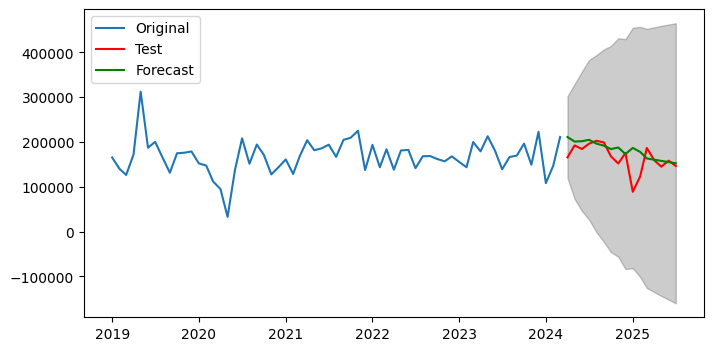

In [83]:
plt.figure(figsize=(8,4))
plt.plot(train.index, train['quantity'], label="Original")
plt.plot(test.index, test['quantity'], label='Test', color='red')
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color='green')
plt.fill_between(forecast_confidence_interval.index,
                 forecast_confidence_interval.iloc[:,0],
                 forecast_confidence_interval.iloc[:,1],
                 color='k', alpha=0.2)
plt.legend()
plt.show()

### Sarimax evaluation

In [84]:
y_true = test['quantity']
y_pred = forecast_mean

In [85]:
sarimax_mse = mean_squared_error(y_true, y_pred)
sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mae = mean_absolute_error(y_true, y_pred)
sarimax_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
accuracy = 100-sarimax_mape

In [86]:
print("\nModel Evaluation: \n")
print(f"MAE: {sarimax_mae:.2f}")
print(f"MSE: {sarimax_mse:.2f}")
print(f"RMSE:  {sarimax_rmse:.2f}")
print(f"MAPE: {sarimax_mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")


Model Evaluation: 

MAE: 21703.44
MSE: 1093994457.31
RMSE:  33075.59
MAPE: 16.89%
Accuracy: 83.11%
